In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**import library**

In [198]:
import numpy as np 
from numpy.random import seed
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge,LinearRegression
# from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
import xgboost as xgb

# DNN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras import metrics
import tensorflow

**讀取檔案**

In [202]:
train = pd.read_csv("drive/MyDrive/store_sales/train.csv", parse_dates=['date'], infer_datetime_format=True, dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'int32',
    }, usecols=['store_nbr', 'family', 'date', 'sales','onpromotion'])


test = pd.read_csv("drive/MyDrive/store_sales/test.csv", parse_dates=['date'], infer_datetime_format=True, dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'int32',
    })

oil = pd.read_csv("drive/MyDrive/store_sales/oil.csv", parse_dates=['date'], infer_datetime_format=True, dtype={
        'dcoilwtico':'float32'
    })

holiday = pd.read_csv("drive/MyDrive/store_sales/holidays_events.csv", parse_dates=['date'], infer_datetime_format=True, dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool'
    })



In [203]:
train['date'] = train.date.dt.to_period('D')
test['date'] = test.date.dt.to_period('D')


In [204]:
train=train.set_index(['store_nbr', 'family', 'date']).sort_index()
test=test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [54]:
start_date = '2017-04-01'
end_date = '2017-08-15'

In [217]:
y = train.drop(['onpromotion'], axis=1).unstack(['store_nbr', 'family']).loc[start_date:end_date,'sales']
y.shape

AttributeError: ignored

In [16]:
y.head()

store_nbr           1            ...                          9           
family     AUTOMOTIVE BABY CARE  ... SCHOOL AND OFFICE SUPPLIES    SEAFOOD
date                             ...                                      
2017-04-01        9.0       0.0  ...                        1.0  40.446999
2017-04-02        4.0       0.0  ...                        3.0  15.000000
2017-04-03       11.0       0.0  ...                        2.0  16.000000
2017-04-04        3.0       0.0  ...                        2.0  15.000000
2017-04-05        5.0       0.0  ...                        1.0  13.373000

[5 rows x 1782 columns]

In [56]:
yvalue=y.values
yvalue

array([[9.000000e+00, 0.000000e+00, 1.000000e+00, ..., 2.625524e+03,
        1.000000e+00, 4.044700e+01],
       [4.000000e+00, 0.000000e+00, 1.000000e+00, ..., 2.303476e+03,
        3.000000e+00, 1.500000e+01],
       [1.100000e+01, 0.000000e+00, 2.000000e+00, ..., 1.697151e+03,
        2.000000e+00, 1.600000e+01],
       ...,
       [1.000000e+00, 0.000000e+00, 1.000000e+00, ..., 1.693607e+03,
        2.000000e+02, 2.000000e+01],
       [1.000000e+00, 0.000000e+00, 6.000000e+00, ..., 1.348425e+03,
        1.820000e+02, 1.700000e+01],
       [4.000000e+00, 0.000000e+00, 4.000000e+00, ..., 2.419729e+03,
        1.210000e+02, 1.600000e+01]], dtype=float32)

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) # 將資料標準化到 0-1

In [185]:
look_back = 10 # 往前看10天

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

final_ans = []

for i in range(1782): # 遍歷每個店家的每個商品
  print("i=",i)

  yvaluetrain = scaler.fit_transform(yvalue[:,i:i+1]) # 每個商品所有日期的價格，進行標準化

  # train_size = int(len(yvaluetrain) * 0.67)
  # test_size = len(yvaluetrain) - train_size
  # train, test = yvaluetrain[0:train_size,:], yvaluetrain[train_size:len(yvaluetrain),:]

  trainX, trainY = create_dataset(yvaluetrain, look_back) # 訓練資料 訓練標籤
  # testX, testY = create_dataset(test, look_back)

  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) # (訓練筆數 , feature數量 , lookback天數)
  # testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  model.fit(trainX, trainY, epochs=1, batch_size=1,verbose=2)


  new_x = []
  tx = yvaluetrain[len(yvaluetrain)-look_back-1:len(yvaluetrain)-1,0] # 取train最後10天來進行預測
  new_x.append(tx)
  new_x = np.array(new_x)
  new_x = np.reshape(new_x, (new_x.shape[0], 1, new_x.shape[1]))


  for j in range(16):
    y_pred_one = model.predict(new_x[:,:,j:])
    y_pred_one = y_pred_one.reshape(1,1,1)
    new_x = np.concatenate([new_x,y_pred_one],axis=2) # 將新預測出來的結果當作下一天的預測資料

  ans_y = new_x[:,:,len(new_x)-17:].reshape(16,1)
  ans_y = scaler.inverse_transform(ans_y) # 將標準化後的資料復原

  final_ans.append(ans_y)




In [78]:
final_ans = np.reshape(final_ans,(1782,16))
final_ans_transpose = final_ans.transpose()
final_ans_transpose
  

array([[4.24987364e+00, 3.14808749e-02, 3.42620182e+00, ...,
        1.85481140e+03, 1.29587524e+02, 1.76863518e+01],
       [4.62978935e+00, 3.68521661e-02, 4.04187107e+00, ...,
        1.44061926e+03, 9.36979752e+01, 1.82420654e+01],
       [4.15360546e+00, 3.85006517e-02, 2.88749623e+00, ...,
        1.33181189e+03, 1.25130356e+02, 1.78679562e+01],
       ...,
       [4.01465511e+00, 5.50510734e-02, 3.43916321e+00, ...,
        1.79897852e+03, 1.26202713e+02, 2.19024715e+01],
       [4.15060997e+00, 5.59359863e-02, 3.40252280e+00, ...,
        1.87237878e+03, 1.05356339e+02, 2.19239769e+01],
       [4.20864439e+00, 5.65540940e-02, 3.37372565e+00, ...,
        1.69492249e+03, 9.73457489e+01, 2.18815460e+01]], dtype=float32)

In [103]:
date_index=[
  '2017-08-16',
  '2017-08-17',
  '2017-08-18',
  '2017-08-19',
  '2017-08-20',
  '2017-08-21',
  '2017-08-22',
  '2017-08-23',
  '2017-08-24',
  '2017-08-25',
  '2017-08-26',
  '2017-08-27',
  '2017-08-28',
  '2017-08-29',
  '2017-08-30',
  '2017-08-31'
]

In [114]:
y_submit = pd.DataFrame(final_ans_transpose.clip(0.0),index=date_index, columns=y.columns)

In [110]:
y_submit.head(16)

store_nbr           1            ...                          9           
family     AUTOMOTIVE BABY CARE  ... SCHOOL AND OFFICE SUPPLIES    SEAFOOD
2017-08-16   4.249874  0.031481  ...                 129.587524  17.686352
2017-08-17   4.629789  0.036852  ...                  93.697975  18.242065
2017-08-18   4.153605  0.038501  ...                 125.130356  17.867956
2017-08-19   3.503367  0.040025  ...                 117.277969  23.324116
2017-08-20   3.403351  0.039509  ...                 132.472046  21.054232
2017-08-21   3.067298  0.040399  ...                 147.969894  22.088320
2017-08-22   3.511214  0.045398  ...                 138.371323  20.099215
2017-08-23   3.980244  0.049286  ...                 107.512993  20.492411
2017-08-24   4.279855  0.051097  ...                  90.620049  20.569801
2017-08-25   4.188149  0.052374  ...                 109.983131  21.094513
2017-08-26   3.932368  0.052609  ...                 115.457397  24.088783
2017-08-27   3.845017  0.052908  ...                 130.535751  23.434435
2017-08-28   3.856677  0.053898  ...                 133.488724  23.490044
2017-08-29   4.014655  0.055051  ...                 126.202713  21.902472
2017-08-30   4.150610  0.055936  ...                 105.356339  21.923977
2017-08-31   4.208644  0.056554  ...                  97.345749  21.881546

[16 rows x 1782 columns]

In [115]:
y_submit = (y_submit
      .stack(['store_nbr', 'family'])
      .reset_index()
      .rename(columns={0:"sales", 'level_0':'date'})
      .set_index(['date', 'store_nbr', 'family'])
      .sort_index())

In [ ]:
y_submit = y_submit.join(test.id).reindex(columns=['id', 'sales'])

In [157]:
for i in range(28512):
  y_submit.iloc[i,y_submit.columns.get_loc('id')]=3000888+i

In [158]:
y_submit=y_submit.astype({"id":int})

In [159]:
y_submit.head() , y_submit.tail()

(                                      id        sales
 date       store_nbr family                          
 2017-08-16 1         AUTOMOTIVE  3000888     4.249874
                      BABY CARE   3000889     0.031481
                      BEAUTY      3000890     3.426202
                      BEVERAGES   3000891  2304.715088
                      BOOKS       3000892     0.185862,
                                                       id        sales
 date       store_nbr family                                          
 2017-08-31 9         POULTRY                     3029395   425.974182
                      PREPARED FOODS              3029396   126.682289
                      PRODUCE                     3029397  1694.922485
                      SCHOOL AND OFFICE SUPPLIES  3029398    97.345749
                      SEAFOOD                     3029399    21.881546)

In [160]:
y_submit.to_csv('submission.csv', index=False)

# 測試 (用來畫圖交作業)

In [205]:
start_date = '2017-04-01'
end_date = '2017-08-15'

y = train.drop(['onpromotion'], axis=1).unstack(['store_nbr', 'family']).loc[start_date:end_date,'sales']
yvalue=y.values

In [206]:
look_back = 30 # 往前看10天

model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [207]:
yvaluetrain = scaler.fit_transform(yvalue[:,0:1])

look_back=30

train_size = int(len(yvaluetrain) * 0.67)
test_size = len(yvaluetrain) - train_size
train, test = yvaluetrain[0:train_size,:], yvaluetrain[train_size:len(yvaluetrain),:]

trainX, trainY = create_dataset(yvaluetrain, look_back) # 訓練資料 訓練標籤
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) # (訓練筆數 , feature數量 , lookback天數)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [215]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [216]:
# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [211]:
trainY = trainY.reshape(106,)

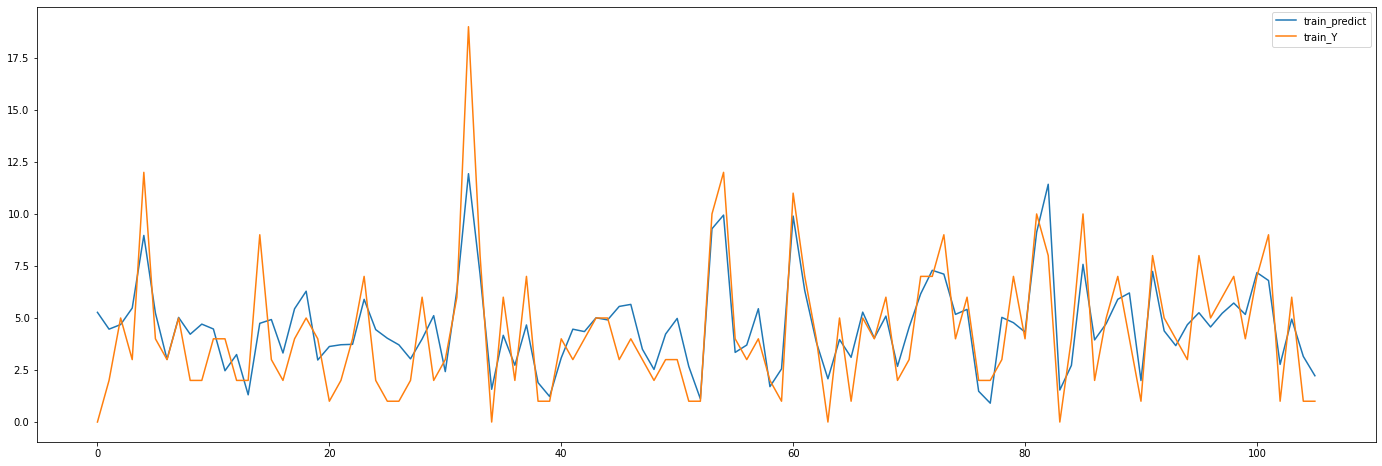

In [212]:
plt.figure(figsize=(24,8))
plt.plot(trainPredict,label='train_predict')
plt.plot(trainY,label='train_Y')
plt.legend()
plt.show()

In [213]:
testY = testY.reshape(15,)

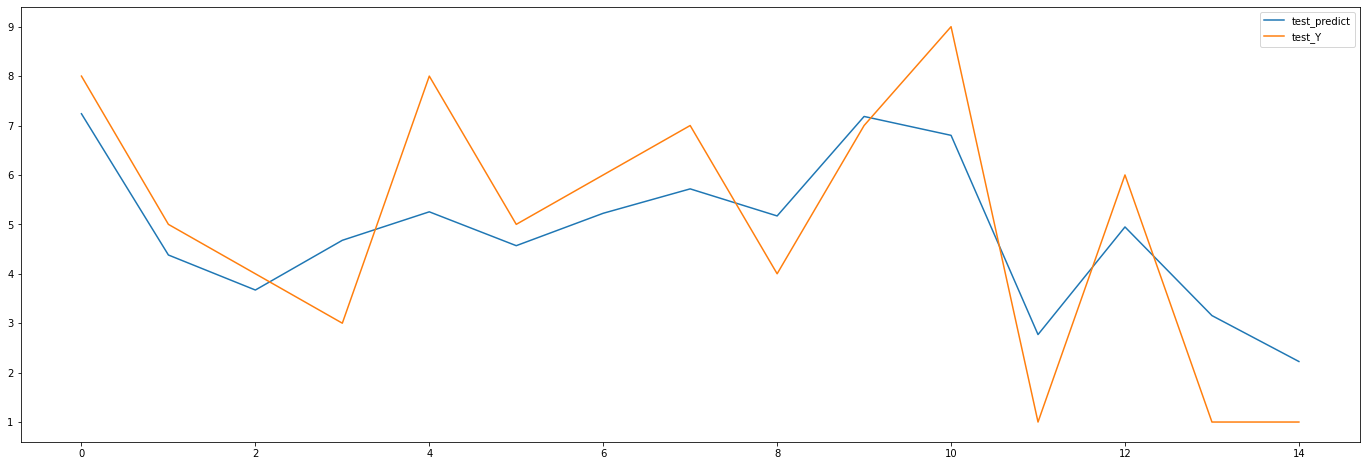

In [214]:
plt.figure(figsize=(24,8))
plt.plot(testPredict,label='test_predict')
plt.plot(testY,label='test_Y')
plt.legend()
plt.show()